# Исследование результатов A/B-теста для интернет-магазина

## Цели и задачи исследования

Крупный интернет-магазин поставил цель увеличить выручку. Вместе с отделом маркетинга был подготовлен список гипотез, которые помогут достичь этой цели. 

**В нашем распоряжении следующие данные:**

- описание гипотез и их ключевые параметры с оценкой по 10-балльной шкале (Reach, Impact и т.д.)
- данные о заказах и выручке с указанием группы A/B-теста
- данные о посетителях сайта с указанием группы A/B-теста

**Наши задачи в ходе исследования:**

- Подготовить данные (проанализировать пропуски, найти и устранить дубликаты, заменить тип данных на корректный)
- Приоритизировать гипотезы
- Проанализировать результаты A/B-теста и ответить на вопросы: можно ли остановить тест? Есть ли победитель?

## Обзор данных

Импортируем библиотеки и отключим предупреждения.

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import datetime as dt

from IPython.display import HTML, display
import warnings

warnings.filterwarnings('ignore')

Отключим автоскролл и scientific notation.

In [2]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Загрузим таблицы с данными и сохраним в соответствующие переменные

In [4]:
hp = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visits = pd.read_csv('visitors.csv')

Объявим функцию `overview` для просмотра данных о таблицах и вывода первых строк.

In [5]:
def overview(df_list):
    """Выводит базовую информацию о таблицах из списка и первые 5 строк каждой таблицы"""
    for x, y in df_list:
        display(HTML('<h2>Таблица ' + y + '</h2>'))
        display(x.head())
        display(x.info())
        display(x.describe())  

Cохраним датафреймы и их названия в список, а затем вызовем нашу функцию для просмотра данных.

In [6]:
tables = [[hp, 'hp'], [orders, 'orders'], [visits, 'visits']]
overview(tables)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,Reach,Impact,Confidence,Efforts
count,9.000,9.000,9.000,9.000
mean,4.778,4.778,5.556,4.889
std,3.153,3.193,3.046,2.804
min,1.000,1.000,1.000,1.000
25%,3.000,3.000,3.000,3.000
50%,3.000,3.000,7.000,5.000
75%,8.000,7.000,8.000,6.000
max,10.000,10.000,9.000,10.000


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,transactionId,visitorId,revenue
count,1197.000,1197.000,1197.000
mean,2155621385.530,2165960143.099,8348.006
std,1229084904.760,1236014192.147,39191.132
min,1062393.000,5114589.000,50.000
25%,1166775572.000,1111826046.000,1220.000
50%,2145193898.000,2217984702.000,2978.000
75%,3237740112.000,3177606451.000,8290.000
max,4293855558.000,4283872382.000,1294500.000


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,visitors
count,62.000
mean,607.290
std,114.401
min,361.000
25%,534.000
50%,624.500
75%,710.500
max,770.000


В столбце с данными о выручке заметен большой разброс данных. Посмотрим на наличие выбросов, построив диаграмму размаха.

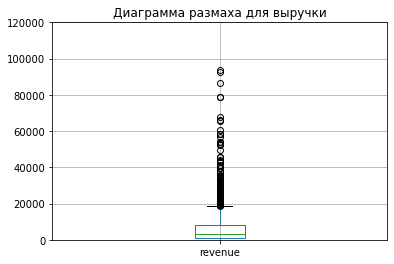

In [7]:
plt.ylim(0,120000)
orders.boxplot(column='revenue')
plt.title('Диаграмма размаха для выручки')
plt.show()

Действительно, налицо большой шлейф выбросов начиная с 20 тысяч и выше. При этом основная масса значений сосредоточена в диапазоне до 10 тысяч.

Также узнаем количество и наименования групп A/B теста при помощи метода `unique()`.

In [8]:
print('Группы A/B теста в таблице orders:', orders.group.unique())
print('Группы A/B теста в таблице visits:',visits.group.unique())

Группы A/B теста в таблице orders: ['B' 'A']
Группы A/B теста в таблице visits: ['A' 'B']


Групп две, посторонних значений не закралось. Всё в порядке.

### Вывод

В нашем распоряжении три таблицы:

- `hp` &mdash; список гипотез с параметрами. Самая маленькая таблица, всего 9 строк.
- `orders` &mdash; данные о заказах за период проведения A/B теста. Самая объемная таблица &mdash; 1197 строк.
- `visits` &mdash; статистика ежедневных посещений сайта в период проведения A/B теста. Строк всего 62, а групп две (A и B), что косвенно свидетельствует о том, что эксперимент, скорее всего, проводился в течение месяца.

Основные наблюдения:

- Явных пропусков не обнаружено &mdash;  количество ненулевых строк одинаково для всех столбцов в каждой из таблиц. 
- Минимальная стоимость заказа &mdash; 50, так что заказов с нулевой стоимостью нет.
- Даты нужно преобразовать из  _object_ в формат _datetime._ Из-за некорректного формата мы пока не можем оценить диапазон и корректность дат &mdash; это мы сделаем в следующей части.
- Оценки в таблице `hp` находятся в пределах 10-балльной шкалы, тут все корректно.
- Очень большой разброс значений _revenue_ (стандартное отклонение &mdash; 39 тысяч), что в целом типично для финансовых данных. Это нужно будет учесть в анализе.

В остальном, данные выглядят корректными, явных аномалий не обнаружено.

## Предобработка данных

### Обработка пропусков

В ходе обзора данных мы не заметили явных пропусков ни в одной из таблиц. На всякий случай выполним проверку при помощи метода `isna()`. 

In [9]:
for x, y in tables:
    print("Пропусков в таблице " +y+ ":") 
    display(x.isna().sum())

Пропусков в таблице hp:


Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

Пропусков в таблице orders:


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Пропусков в таблице visits:


date        0
group       0
visitors    0
dtype: int64

Пропусков не обнаружено, идем дальше.

### Замена типа данных

Преобразуем дату в формат _datetime_ для двух таблиц: `orders` и `visits`. Затем проверим, повторно выведя типы данных.

In [10]:
table2 = [orders, visits]

for table in table2:
    table['date'] = table['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
     )
    display(table.dtypes)

transactionId             int64
visitorId                 int64
date             datetime64[ns]
revenue                   int64
group                    object
dtype: object

date        datetime64[ns]
group               object
visitors             int64
dtype: object

Преобразование выполнено успешно. Теперь посмотрим на диапазон дат, вызвав метод describe().

In [11]:
for table in table2:
    display(table['date'].describe())

count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

count                      62
unique                     31
top       2019-08-02 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

Видим, что уникальных дат ровно 31 в диапазоне с 1 по 31 августа. Это подтверждает предыдущее предположение о том, что A/B тест проводился в течение месяца. 

Заодно мы убедились, что все данные входят в один диапазон &mdash; ошибок или аномалий нет.

Другие столбцы не требуют преобразования типа данных.

### Обработка дубликатов

Проверим наши таблицы на наличие дубликатов. В файле с гипотезами они маловероятны, а в двух других возможны. 

In [12]:
for x, y in tables:
    print("Дубликатов в таблице", y, "-", x.duplicated().sum())

Дубликатов в таблице hp - 0
Дубликатов в таблице orders - 0
Дубликатов в таблице visits - 0


Ранее мы проверили количество групп A/B теста и убедились, что групп две. Также стоит проверить, нет ли аномалий в распределении участников по группам.

In [13]:
print('Всего уникальных покупателей:', orders.visitorId.nunique())
print('Уникальных покупателей группы A:',orders.query('group == "A"').visitorId.nunique())
print('Уникальных покупателей группы B:',orders.query('group == "B"').visitorId.nunique())

Всего уникальных покупателей: 1031
Уникальных покупателей группы A: 503
Уникальных покупателей группы B: 586


Проведя несложные вычисления _(503+586 > 1031),_ понимаем, что часть покупателей записана в обе группы &mdash; и A, и В. Здесь явная ошибка!

Разница составляет 58 пользователей _((503+586) - 1031 = 58)_. Проверим это, сделав срез данных из `orders` с логическим условием, что пользователь одновременно входит в обе группы. 

In [14]:
groupA = orders.query('group == "A"').visitorId.unique()
groupB = orders.query('group == "B"').visitorId.unique()

print(orders.query('visitorId in @groupA & visitorId in @groupB').visitorId.nunique())

58


Цифры сошлись. Действительно, 58 пользователей по ошибке указаны как принадлежащие к обеим группам. Эти строки придется удалить, так как мы не можем произвольно отнести их в одну либо другую группу &mdash; это будет нарушением эксперимента.

In [15]:
# отфильтруем этих пользователей из датафрейма и пересохраним его
orders = orders.query('~(visitorId in @groupA & visitorId in @groupB)')

# выполним проверку
print('Всего уникальных покупателей:', orders.visitorId.nunique())
print('Уникальных покупателей группы A:',orders.query('group == "A"').visitorId.nunique())
print('Уникальных покупателей группы B:',orders.query('group == "B"').visitorId.nunique())
print('Проверочная сумма:',
      str(orders.query('group == "A"').visitorId.nunique() + orders.query('group == "B"').visitorId.nunique()))

Всего уникальных покупателей: 973
Уникальных покупателей группы A: 445
Уникальных покупателей группы B: 528
Проверочная сумма: 973


Проверочная сумма сошлась, теперь все в порядке: каждый из уникальных покупателей принадлежит либо к группе A, либо к группе B.

### Обработка аномальных значений

На диаграмме размаха мы уже отмечали, что в данных о заказах присутствуют выбросы. Более подробной оценкой аномалий мы займемся позже. Пока что просто примем во внимание, что эти выбросы могут &mdash; и скорее всего будут &mdash; влиять на подсчет показателей.

### Вывод

В ходе предобработки данных мы:

- Проверили таблицы на наличие полных дубликатов и их не обнаружили.
- Убедились, что явных пропусков в таблицах нет.
- Привели даты к типу данных _datetime_ и убедились, что замена прошла корректно.
- Выяснили, что диапазон дат в данных &mdash; ровно один месяц (август 2019 года), дат вне этого диапазона нет.
- Проверили количество уникальных покупателей в группах теста и обнаружили 58 пользователей, которые записаны **в обе группы**. Эти строки мы удалили, чтобы не нарушать чистоту эксперимента.

## Приоритизация гипотез

Вместе с отделом маркетинга мы выдвинули 9 гипотез, но проверять их все не будем &mdash; слишком затратно. Гипотезы нужно приоритизировать и выбрать наиболее подходящие.

Сначала посмотрим еще раз на таблицу и выведем ее целиком.

In [16]:
pd.set_option('max_colwidth', -1)
hp

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Видим, что идеи самые разные: от небольших "косметических" изменений на сайте (показ баннеров, изменение цвета фона) до проведения рекламных акций и даже создания целой службы доставки. Понятно, что затратность и степень влияния на пользователей у них разные. Это отражено в оценке параметров: Reach, Impact, Confidence, Efforts.

Чтобы приоритизировать гипотезы, воспользуемся **фрейморком ICE**. Он учитывает 3 параметра из 4: Impact, Confidence, Efforts.

Рассчитаем ICE по формуле, а затем выведем гипотезы в порядке убывания приоритета.

In [17]:
hp['ICE'] = (hp['Impact'] * hp['Confidence'])/hp['Efforts']
hp[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


Наивысший приоритет присвоен **гипотезе 8 &mdash; предложение скидок ко дню рождения**. 

Но так ли уж хороша эта гипотеза? Во-первых, пользователи могут неправильно указывать день рождения или не указывать его вовсе, и тогда идея не сработает. Кроме того, день рождения всего раз в году, и на этом много не заработаешь. 

На 2 и 3 месте  &mdash; гипотезы № 0 и 7. Кажется, что у них больший потенциал: запуск новых каналов для привлечения трафика или добавление новых форм подписки. Попробуем применить **другой фреймворк &mdash; RICE**. Отличие его в том, что он учитывает также охват (Reach).

Выполним новый расчет и отсортируем гипотезы по убыванию приоритета.

In [18]:
hp['RICE'] = (hp['Reach'] * hp['Impact'] * hp['Confidence'])/hp['Efforts']
hp[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000


Для удобства сравнения отобразим приоритеты, присвоенные гипотезам, на диаграмме.

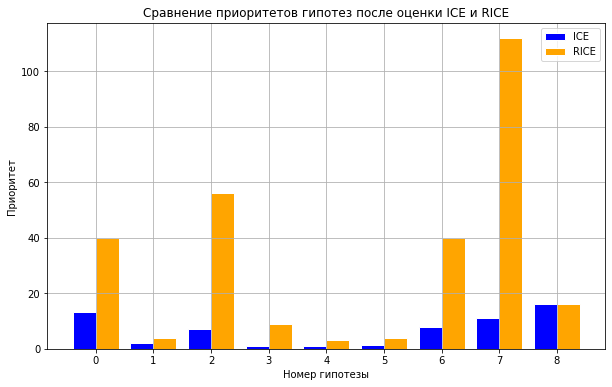

In [19]:
fig, ax = plt.subplots(figsize=(10,6))

# задаем значения для оси X и ширины столбцов
x = np.arange(9)
width = 0.40

# задаем значения для столбцов диаграммы
plt.bar(x-0.2, hp['ICE'], width, color='blue', edgecolor='white', label='ICE')
plt.bar(x+0.2, hp['RICE'], width, color='orange', edgecolor='white', label='RICE')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
ax.grid()

plt.title('Сравнение приоритетов гипотез после оценки ICE и RICE')
plt.xlabel('Номер гипотезы')
plt.ylabel('Приоритет')
plt.legend()
plt.show()

В первую тройку снова вошли **гипотезы 0 и 7**, только теперь №7 &mdash; на первом месте. Также высокий приоритет у **гипотезы 2** &mdash; добавление блоков с рекомендациями. 

В фреймворке RICE наша гипотеза с днями рождения (№8) получила уже не такой высокий приоритет.

Так произошло именно потому, что при расчете ICE мы не учитывали, какая доля аудитории будет охвачена. Изменения в дизайне и наполнении сайта, который посещают все пользователи, затронут большую долю аудитории. Аналогично с новыми каналами трафика. 

А вот акция по поводу дня рождения коснется только небольшой доли пользователей, тем более если мы будем тестировать эту гипотезу на протяжении всего лишь месяца.

### Вывод

Мы провели приоритизацию гипотез, пользуясь двумя фреймворками &mdash; ICE и RICE. 

В первом случае наивысший приоритет получили **гипотезы 8, 0 и 7**. Поскольку результат вызвал сомнения, мы решили перепроверить его при помощи другого традиционного фрейморка RICE.

Во втором случае наивысший приоритет был присвоен **гипотезам 7, 2 и 0**. Полученная разница объясняется тем, что в первом случае не учитывался охват аудитории.

Также отметим, что **гипотезы 7 и 0** вошли в топ в обоих случаях. В первую очередь стоит протестировать именно их, а также гипотезу 2, поскольку они оптимальны по сочетанию максимального эффекта, минимальных затрат и нашей уверенности в результате.

## Анализ A/B-теста

### График кумулятивной выручки

Итак, мы выбрали и проверили одну из гипотез при помощи A/B-теста. Теперь проанализируем результаты A/B-теста, данные о которых есть в двух таблицах: `orders` и `visits`.

Сначала рассчитаем кумулятивную выручку по группам. 

В отдельный фрейм сохраним уникальные пары "дата-группа теста", то есть на каждую дату придется по две группы.

In [20]:
datesGroups = orders[['date','group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Далее добавим данные по выручке с накоплением. В каждую строку с датой запишем сумму выручки за эту дату и предшествующие ей.

In [21]:
revenueCum = (datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date' : 'max', 
          'group' : 'max', 
          'transactionId' : 'nunique', 
          'visitorId' : 'nunique', 
          'revenue' : 'sum'}), axis=1)
    .sort_values(by=['date','group']))

# переименуем столбцы
revenueCum.columns = ['date', 'group', 'orders', 'buyers', 'revenue']

Сохраним данные по каждой группе в отдельные датафреймы и выведем начало одного из них, чтобы посмотреть, что получилось.

In [22]:
revenueCumA = revenueCum.query('group == "A"')
revenueCumB = revenueCum.query('group == "B"')
revenueCumB.head()

,date,group,orders,buyers,revenue
66,2019-08-01,B,17,17,59758
173,2019-08-02,B,40,39,221801
383,2019-08-03,B,54,53,288850
498,2019-08-04,B,68,66,385740
699,2019-08-05,B,89,87,475648


Видим, что в столбце `group` - та группа, по которой мы фильтровали. Количество заказов и клиентов, а также суммарная выручка возрастают с каждой строкой, то есть идет подсчёт с накоплением. 

Теперь выведем данные о кумулятивной выручке по дням и группам на графике.

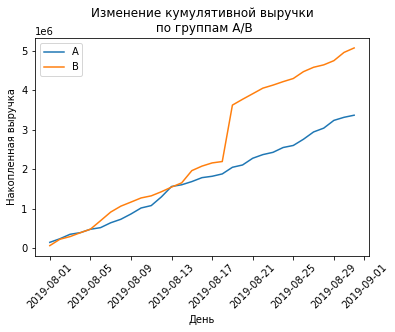

In [23]:
plt.plot(revenueCumA['date'], revenueCumA['revenue'], label='A')
plt.plot(revenueCumB['date'], revenueCumB['revenue'], label='B')

plt.xlabel('День')
plt.ylabel('Накопленная выручка')
plt.xticks(rotation=45)
plt.title('Изменение кумулятивной выручки\n по группам A/B')
plt.legend()
plt.show()

У группы A накопительная выручка равномерно увеличивается на протяжении всего теста. Это хороший показатель. А вот у группы B заметен резкий скачок после 17 августа. _До этой даты_ разницы в средней выручкой между сегментами практически не было.

Этот скачок &mdash; вероятно, следствие чрезмерно дорогих заказов, а значит, делать вывод о том, что группа B побеждает в тесте, пока преждевременно. 

### График кумулятивного среднего чека и относительное изменение среднего чека

Чтобы найти кумулятивный средний чек, разделим кумулятивную выручку на число заказов. Далее по этим данным построим график.

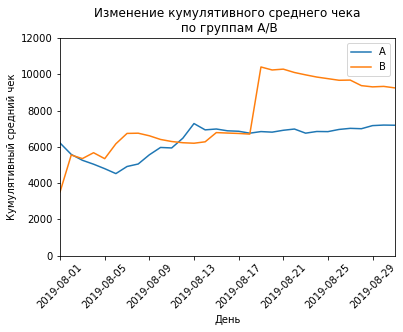

In [24]:
plt.plot(revenueCumA['date'], revenueCumA['revenue']/revenueCumA['orders'], label='A')
plt.plot(revenueCumB['date'], revenueCumB['revenue']/revenueCumB['orders'], label='B')

# изменим масштаб оси
plt.axis(["2019-08-01", '2019-08-31', 0, 12000]) 

plt.xlabel('День')
plt.ylabel('Кумулятивный средний чек')
plt.xticks(rotation=45)

plt.title('Изменение кумулятивного среднего чека\n по группам A/B')
plt.legend()
plt.show()

В первой половине месяца значения среднего чека колеблются в небольшом диапазоне (4-6 тысяч). Для группы А чек устанавливается на одном значении во второй половине теста, а для группы B наблюдается резкий подъем. Вероятно, здесь сказываются те самые крупные заказы.

Посмотрим на относительное изменение кумулятивного чека. Для этого сначала соберем данные по кумулятивной выручке в один датафрейм, затем построим график.

In [25]:
# собираем данные в одном датафрейме
revenueCumAB = revenueCumA.merge(revenueCumB, on='date', how='left', suffixes=['A', 'B'])
revenueCumAB.head()

,date,groupA,ordersA,buyersA,revenueA,groupB,ordersB,buyersB,revenueB
0,2019-08-01,A,23,19,142779,B,17,17,59758
1,2019-08-02,A,42,36,234381,B,40,39,221801
2,2019-08-03,A,66,60,346854,B,54,53,288850
3,2019-08-04,A,77,71,388030,B,68,66,385740
4,2019-08-05,A,99,92,474413,B,89,87,475648


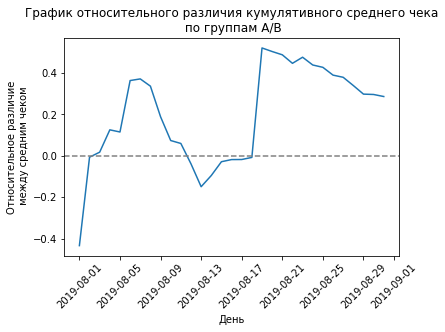

In [26]:
# cтроим отношение средних чеков
plt.plot(revenueCumAB['date'], 
         (revenueCumAB['revenueB']/revenueCumAB['ordersB'])/
         (revenueCumAB['revenueA']/revenueCumAB['ordersA'])-1)

# добавим ось X
plt.axhline(y=0, color='grey', linestyle='--')

plt.xlabel('День')
plt.ylabel('Относительное различие\n между средним чеком')
plt.xticks(rotation=45)
plt.title('График относительного различия кумулятивного среднего чека\n по группам A/B')
plt.show()

В начале теста группа B значительно проигрывала группе A по среднему чеку, но затем пошел рост: большую часть месяца **средний чек в группе B был выше**. 

Стабильной тенденцию назвать нельзя: в середине месяца опять произошел спад. Свою роль могли сыграть выбросы (дорогие заказы) или большое количество заказов в группе А, которые временно перетянули на себя средний чек.

### График кумулятивной конверсии и ее относительного изменения

Чтобы вычислить конверсию, сначала подсчитаем кумулятивное количество посетителей в каждой группе теста. 

In [27]:
visitsCum = (datesGroups.apply
            (lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])]
            .agg({
                'date': 'max',
                'group': 'max',
                'visitors': 'sum'
             }), 
             axis=1)
             .sort_values(by=['date','group']))

visitsCum.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединим данные по кумулятивной выручке с данными по кумулятивным посетителям в один датафрейм.

In [28]:
df = revenueCum.merge(visitsCum, on=['date', 'group'], how='left')
df.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Рассчитаем кумулятивную конверсию, разделив количество заказов на количество посетителей (все метрики накопительные).

In [29]:
df['conversion'] = df['orders']/df['visitors']

# выделим данные по группам A и B в отдельные датафреймы

conversionA = df[df['group'] == 'A']
conversionB = df[df['group'] == 'B']

conversionA.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.032
2,2019-08-02,A,42,36,234381,1338,0.031
4,2019-08-03,A,66,60,346854,1845,0.036
6,2019-08-04,A,77,71,388030,2562,0.030
8,2019-08-05,A,99,92,474413,3318,0.030


Построим график, чтобы сравнить накопительную конверсию для групп A и B.

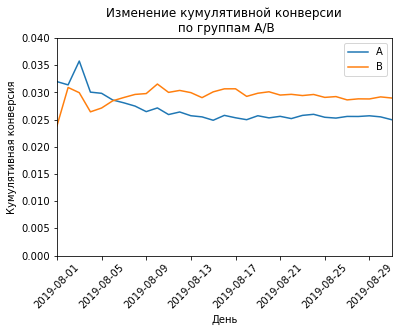

In [30]:
plt.plot(conversionA['date'], conversionA['conversion'], label='A')
plt.plot(conversionB['date'], conversionB['conversion'], label='B')

# отрегулируем масштаб 
plt.axis(["2019-08-01", '2019-08-31', 0, 0.04]) 

plt.xlabel('День')
plt.ylabel('Кумулятивная конверсия')
plt.xticks(rotation=45)

plt.title('Изменение кумулятивной конверсии\n по группам A/B')
plt.legend()
plt.show()

Линии на графике почти симметричны! Сначала конверсия в группе A была выше, затем произошел спад. У группы B всё с точностью наоборот &mdash; сначала она проигрывала по конверсии, затем оставшуюся часть теста лидировала. 

Уже на второй неделе теста значения конверсии для обеих групп зафиксировались: конверсия в группе B в среднем **превышала конверсию в группе A примерно на 0,005**. 

Различие совсем незначительно. Можно ли считать это неслучайным результатом, мы узнаем позднее при оценке статистической значимости. А сейчас оценим относительное изменение конверсии для групп A и B.

In [31]:
# собираем данные в одном датафрейме
conversionAB = conversionA.merge(conversionB, on='date', how='left', suffixes=['A', 'B'])
conversionAB.head()

,date,groupA,ordersA,buyersA,revenueA,visitorsA,conversionA,groupB,ordersB,buyersB,revenueB,visitorsB,conversionB
0,2019-08-01,A,23,19,142779,719,0.032,B,17,17,59758,713,0.024
1,2019-08-02,A,42,36,234381,1338,0.031,B,40,39,221801,1294,0.031
2,2019-08-03,A,66,60,346854,1845,0.036,B,54,53,288850,1803,0.030
3,2019-08-04,A,77,71,388030,2562,0.030,B,68,66,385740,2573,0.026
4,2019-08-05,A,99,92,474413,3318,0.030,B,89,87,475648,3280,0.027


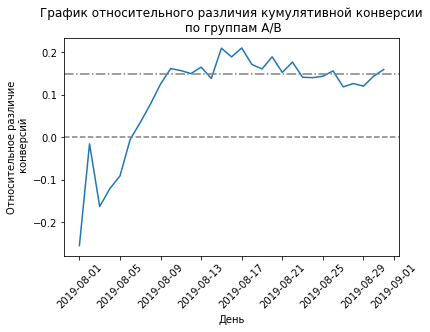

In [32]:
# cтроим отношение конверсий
plt.plot(conversionAB['date'], 
         conversionAB['conversionB']/
         conversionAB['conversionA'] -1)

# добавляем горизонтальные оси
plt.axhline(y=0, color='grey', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='-.')

plt.xticks(rotation=45)
plt.xlabel('День')
plt.ylabel('Относительное различие\n конверсий')
plt.title('График относительного различия кумулятивной конверсии\n по группам A/B')
plt.show()

В начале теста группа B явно проигрывала по конверсии. Затем наблюдаем уверенный рост. Начиная со второй декады месяца, различие в конверсиях установилось примерно на одном значении _(0,15)._

Пока что, с учетом аномалий, можно считать, что группа B показала лучшие результаты по конверсии, чем группа A. 

###  Точечный график количества заказов. Определение аномалий

На графиках кумулятивной выручки и среднего чека мы видели неожиданные всплески. Что, если они связаны с **аномально большим** количеством заказов? Возможно, в базе интернет-магазина есть один или несколько пользователей с нетипичным сценарием покупок ("шопоголики"). В таком случае, они могут искажать картину A/B теста. 

Изучим распределение количества заказов по пользователям.

In [33]:
orders_n = (orders
            .groupby('visitorId', as_index=False)
            .agg({'transactionId': 'nunique'}))

# переименуем столбцы
orders_n.columns = ['visitorId', 'orders_n']

# отсортируем по убыванию количества заказов
orders_n.sort_values(by='orders_n', ascending=False).head()

,visitorId,orders_n
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


Максимальное количество заказов &mdash; 3. Не так уж много за месяц. С другой стороны, если все делают по 1 покупке, то 3 &mdash; уже много.

Посмотрим на диаграмму рассеяния.

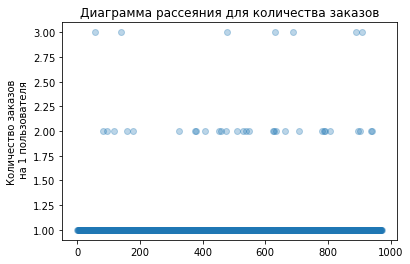

In [34]:
xvalues = pd.Series(range(0,len(orders_n)))

plt.scatter(xvalues, orders_n['orders_n'], alpha=0.3)

plt.title('Диаграмма рассеяния для количества заказов')
plt.ylabel('Количество заказов\n на 1 пользователя')
plt.show()

Действительно, подавляющее большинство пользователей совершило за месяц всего по одной покупке. Меньшая доля совершила по 2 покупки, и уж совсем единицы сделали по 3 покупки в месяц.

Если только у нас не продуктовый интернет-магазин, то частота покупок раз в месяц &mdash; достаточно типичная картина. Вероятно, 2-3 покупки можно отнести к выбросам. Чтобы точнее определить эту границу, рассчитаем 95-й и 99-й перцентили количества заказов.

In [35]:
print(np.percentile(orders_n['orders_n'], [95, 99]))

[1. 2.]


Всего 5% пользователей заказывали более 1 раза, а 1% &mdash; более 2 раз. Примем 1 заказ за верхнюю границу. Всё, что более, отнесем к аномальному количеству. Фильтрацией данных мы займемся позже при оценке статзначимости.

###  Точечный график стоимости заказов. Определение аномалий

При наличии аномалий стоимость одного заказа &mdash; фактор, который также может заметно влиять на показатели выручки и среднего чека.

Оценим разброс данных. Предварительно мы уже видели (на диаграмме размаха), что выбросы точно есть.

In [36]:
xvalues2 = pd.Series(range(0,len(orders['revenue'])))

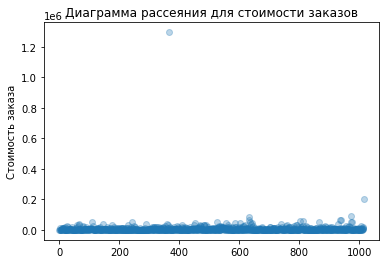

In [37]:
plt.scatter(x=xvalues2, y=orders.revenue, alpha=0.3)
plt.title('Диаграмма рассеяния для стоимости заказов')
plt.ylabel('Стоимость заказа')
plt.show()

Преобладающая доля заказов имеет **стоимость до 100 тысяч**. Есть и сильно выбивающиеся значения, например 1 200 000 &mdash; нетипичная сумма заказа для интернет-магазина. Точнее по графику сказать сложно, поэтому повторим график с измененным масштабом.

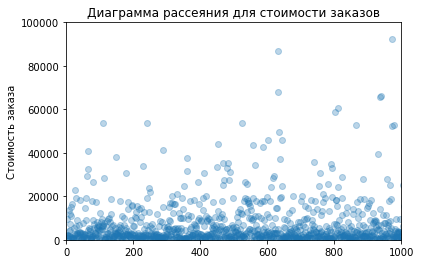

In [38]:
plt.scatter(x=xvalues2, y=orders.revenue, alpha=0.3)

# отрегулируем масштаб
plt.axis([0, 1000, 0, 100000]) 
plt.title('Диаграмма рассеяния для стоимости заказов')
plt.ylabel('Стоимость заказа')
plt.show()

Теперь видим, что основная масса заказов &mdash; на сумму до 5-10 тысяч. Все, что дороже 20 тысяч, встречается уже сравнительно редко.

Чтобы точнее определить порог редких значений, найдем 95-й и 99-й перцентили для стоимости заказа.

In [39]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Итак, всего 5% заказов стоит дороже 27 тысяч и 1% &mdash; дороже 54 тысяч. Для наших будущих расчетов проведем границу по 95-му перцентилю. Всё, что дороже, будем считать аномально дорогими заказами.

### Оценка статзначимости в конверсии и среднем чеке по «сырым» данным

На графиках мы наблюдали различия в конверсии и среднем чеке. Теперь проверим, насколько случайны или неслучайны эти различия. Для этого воспользуемся статистическим тестом. 

Как нам уже известно, в данных есть выбросы, а значит, параметрические тесты, такие как Хи-квадрат, будут неточными. Особенностям нашей выборки удовлетворяет _непараметрический тест Манна-Уитни._

Подготовим таблицу для проверки тестом.

Сначала сформируем две таблицы с покупателями из каждой группы и количеством заказов, сделанным каждым покупателем.

In [40]:
buyersA = (orders.query('group == "A"')
          .groupby('visitorId', as_index=False)
          .agg({'transactionId': 'nunique'}))

# переименуем столбцы
buyersA.columns = ['user', 'orders']

# аналогично сгруппируем покупателей и заказы из второй группы
buyersB = (orders.query('group == "B"')
          .groupby('visitorId', as_index=False)
          .agg({'transactionId': 'nunique'}))

# переименуем столбцы
buyersB.columns = ['user', 'orders']

# выведем начало таблиц

for x in [buyersA, buyersB]:
    display(x.head())

,user,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


,user,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


В отдельные переменные сохраним количество посетителей в группах A и B за весь период.

In [41]:
total_visits_A = visits.query('group == "A"')['visitors'].sum()
total_visits_B = visits.query('group == "B"')['visitors'].sum()

print('Общее количество посетителей в группе A:', total_visits_A)
print('Общее количество посетителей в группе B:', total_visits_B)

Общее количество посетителей в группе A: 18736
Общее количество посетителей в группе B: 18916


Подсчитаем количество посетителей с нулевым количеством заказов как разницу между **общим количеством посетителей** в той или иной группе и **длиной таблиц** со списками покупателей: `buyersA` или `buyersB`.

Сформируем датафрейм с нулями в каждой строчке. Их количество будет равно количеству посетителей, не совершивших ни одного заказа. 

Датафреймов будет два &mdash; по одному для каждой группы теста.

In [42]:
zeroA = pd.DataFrame({'orders' : [0]*(total_visits_A - len(buyersA.orders))})

zeroB = pd.DataFrame({'orders' : [0]*(total_visits_B - len(buyersB.orders))})

Теперь создадим переменные `sampleA` и `sampleB`, в которых каждая строчка будет соответствовать количеству заказов, сделанному уникальным пользователем. 

Для этого объединим столбец _orders_ из таблиц `buyersA` и `buyersB` с таблицами, содержащими нулевое количество заказов.

In [43]:
sampleA = pd.concat([buyersA['orders'].to_frame(), zeroA]).reset_index(drop=True)

sampleB = pd.concat([buyersB['orders'].to_frame(), zeroB]).reset_index(drop=True)

sampleA

,orders
0,1
1,1
2,1
3,1
4,1
...,...
18731,0
18732,0
18733,0
18734,0


Убедились, что получилось то, что нужно. Теперь применим статистический критерий к нашим двум переменным. Проверка двухсторонняя, поэтому в качестве аргумента укажем 'two-sided'.

Также вычислим **относительное различие** между конверсией в группе A и B. Для расчета конверсии используем метод _mean()_ &mdash; отношение количества заказов к количеству всех посетителей и будет конверсией.

Сформулируем нулевую и альтернативную гипотезы:

- _H0_ - **между выборками нет статистически значимых различий в конверсии**.
- _H1_ - **конверсия в двух выборках различна**.

In [44]:
# задаем уровень статистической значимости
alpha = 0.05  

results = stats.mannwhitneyu(sampleA, sampleB, True, alternative='two-sided')

print('p-значение: ', results[1])

if results[1] < alpha:
    print('Отвергаем нулевую гипотезу H0: разница статистически значима')
else:
    print( 'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

print("Относительное различие между конверсиями: {0:.3f}".format(sampleB.orders.mean() / sampleA.orders.mean() - 1))

p-значение:  0.011018084110014691
Отвергаем нулевую гипотезу H0: разница статистически значима
Относительное различие между конверсиями: 0.160


P-value меньше принятого нами уровня статистической значимости. Поэтому мы **отвергаем нулевую гипотезу** о том, что между нашими выборками нет различий.

Также анализ "сырых данных" показывает, что различие между конверсиями составляет примерно 16% в пользу группы B.

Теперь изучим различия в среднем чеке на "сырых данных".

Применим критерий Манна-Уитни с двухсторонней проверкой и уровнем значимости 5%. Кроме того, рассчитаем относительное различие между средним чеком в группах A и B.

In [45]:
results = stats.mannwhitneyu(
    orders.query('group == "A"')['revenue'], 
    orders.query('group == "B"')['revenue'], 
    True, 
    alternative='two-sided')

print('p-значение: ', results[1])

if results[1] < alpha:
    print('Отвергаем нулевую гипотезу H0: разница статистически значима')
else:
    print( 'Не получилось отвергнуть нулевую гипотезу, вывод о различии среднего чека сделать нельзя')

print("Относительное различие между средним чеком: {0:.3f}"
      .format(
          orders.query('group == "B"')['revenue'].mean() / 
          orders.query('group == "A"')['revenue'].mean() - 1))

p-значение:  0.8294908998149533
Не получилось отвергнуть нулевую гипотезу, вывод о различии среднего чека сделать нельзя
Относительное различие между средним чеком: 0.287


Вывод: несмотря на зафиксированное относительное различие, у нас нет никаких оснований отклонить нулевую гипотезу. **Статистически значимых различий** в среднем чеке на "сырых данных" нет. 

### Оценка статзначимости в конверсии и среднем чеке по «очищенным» данным

В результате анализа количества заказов на покупателя и стоимости заказов мы решили, что к аномальным пользователям можно отнести:

- Тех, кто сделал больше 1 заказа
- Тех, у кого стоимость заказа превышает 27 тысяч

Подготовим данные для анализа с учетом этих ограничений.

Сначала сделаем срезы с числом заказов > 1 из таблиц `buyersA` и `buyersB` и объединим их. Получим список _user id_ с аномальным количеством заказов.

In [46]:
anomaly1 = pd.concat([buyersA.query('orders > 1')['user'], buyersB.query('orders > 1')['user']])
anomaly1.head()

36     366673373 
58     611059232 
64     678354126 
72     759473111 
171    1617417821
Name: user, dtype: int64

Теперь сделаем срез со стоимостью заказа > 27000 из таблицы `orders`. Получим список _user id_ с аномально дорогими заказами.

In [47]:
anomaly2 = orders.query('revenue > 27000')['visitorId']
anomaly2.name = 'user'
anomaly2.head()

73     2947100995
77     787824685 
78     3288820196
131    2254586615
137    1211585711
Name: user, dtype: int64

Объединим списки "аномальных" пользователей методом `concat()`, устраним дубликаты и подсчитаем итоговое количество.

In [48]:
anomaly = (pd.concat([anomaly1, anomaly2], axis=0)
           .reset_index(drop=True)
          .drop_duplicates())
print('Всего аномальных пользователей:', len(anomaly))

Всего аномальных пользователей: 86


Сделаем срез покупателей по внешнему Series со списком аномальных покупателей, исключив их из выборки. 

Сохраним новые выборки в переменные `sampleA_filter` и `sampleB_filter`, где, как и раньше, количество нулей будет соответствовать количеству посетителей, не сделавших заказ на сайте.

In [49]:
sampleA_filter = (pd.concat(
                        [buyersA.query('~(user in @anomaly)')['orders']
                        .to_frame(), zeroA])
                        .reset_index(drop=True)
                 )

sampleB_filter = (pd.concat(
                        [buyersB.query('~(user in @anomaly)')['orders']
                        .to_frame(), zeroB])
                        .reset_index(drop=True)
                 )

Как и раньше, примем alpha = 0.05 и применим двусторонний критерий Манна-Уитни. Выдвинем следующие гипотезы:

* _Нулевая гипотеза H0:_ **конверсия в двух выборках не различается.**
* _Альтернативная гипотеза H1:_ **между выборками есть статистически значимое различие в конверсии**.

In [50]:
results = stats.mannwhitneyu(sampleA_filter, sampleB_filter, True, alternative='two-sided')

print('p-значение: ', results[1])

if results[1] < alpha:
    print('Отвергаем нулевую гипотезу H0: разница статистически значима')
else:
    print( 'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

print("Относительное различие между конверсиями: {0:.3f}"
      .format(sampleB_filter.orders.mean() / sampleA_filter.orders.mean() - 1))

p-значение:  0.01593020716573976
Отвергаем нулевую гипотезу H0: разница статистически значима
Относительное различие между конверсиями: 0.174


От аномалий мы избавились, но вывод не изменился: **нулевую гипотезу отвергаем, различие есть**. 

Кроме того, на "очищенных данных" относительное различие конверсий стало чуть заметнее (0.174 против 0.16). 

Сравним теперь средний чек на очищенных данных.

In [51]:
results = stats.mannwhitneyu(
    orders.query('group == "A" & ~(visitorId in @anomaly)')['revenue'], 
    orders.query('group == "B" & ~(visitorId in @anomaly)')['revenue'], 
    True, 
    alternative='two-sided')

print('p-значение: ', results[1])

if results[1] < alpha:
    print('Отвергаем нулевую гипотезу H0: разница между средним чеком статистически значима')
else:
    print( 'Не получилось отвергнуть нулевую гипотезу, вывод о различии в среднем чеке сделать нельзя')

print("Относительное различие между средним чеком: {0:.3f}"
      .format(
          orders.query('group == "B" & ~(visitorId in @anomaly)')['revenue'].mean() / 
          orders.query('group == "A" & ~(visitorId in @anomaly)')['revenue'].mean() - 1))

p-значение:  0.7271286894009963
Не получилось отвергнуть нулевую гипотезу, вывод о различии в среднем чеке сделать нельзя
Относительное различие между средним чеком: -0.034


Здесь вывод тот же, что и на "сырых данных": **существенных различий по среднему чеку между группами нет**. 

Мы видим, что при устранении дорогих заказов относительное различие сместилось в пользу группы А. Получается, средний чек в обеих группах плюс-минус одинаков и значения колеблются лишь под влиянием выбросов.

Подведем итоги A/B теста:

- Статистически значимых различий по среднему чеку между группами A и B нет. Это верно как для "сырых", так и для "очищенных" данных.
- Зато в конверсии есть различие: конверсия в группе B выше примерно на 16%, чем в группе A. 
- График относительного изменения конверсии показывает, что конверсия в группе B зафиксировалась на одном значении и стабильно превышает конверсию в группе B.
- График относительного изменения среднего чека, к сожалению, не показал стабильной тенденции. Большую часть месяца группа B показывала лучшие результаты по среднему чеку, но есть основания предполагать, что это следствие выбросов. Сделать определенный вывод по нему нельзя.

Исходя из полученных результатов, мы можем остановить тест и признать победителем группу B. По крайней мере, в конверсии улучшение достигнуто. 

### Вывод

Мы провели A/B тест по одной из выбранных гипотез в течение месяца (августа 2019 года) и проанализировали результаты &mdash; такие показатели, как выручка, средний чек и конверсия. 

Наши наблюдения:

- **Кумулятивная выручка** в группах A и B равномерно увеличивалась на протяжении всего теста. До 17 августа разницы между сегментами практически не было, а потом у группы B произошел скачок &mdash; вероятно, вследствие дорогих заказов.
- Аналогично с **кумулятивным средним чеком**. В первой половине месяца разницы между сегментами практически не было. Далее средний чек у группы B резко возрос. Это заставило нас подозревать наличие аномалий: особенно крупных заказов или большого количества заказов.
- **График относительного различия в среднем чеке** показал крайне нестабильную картину: различие резко колебалось в течение всего месяца.
- **График кумулятивной конверсии** показал, что этот показатель зафиксировался на второй неделе теста. При этом конверсия в группе B ненамного, но стабильно опережала группу A.
- По графику **относительного различия в конверсии** видим, что в группе B сначала наблюдался рост, затем различие зафиксировалось.
- Построив точечные графики, мы выявили аномалии: совершение 2-3 заказов в течение месяца, а также заказы стоимостью более 27000.
- Далее, чтобы выяснить, значима ли наблюдаемая разница в показателях конверсии и среднего чека, мы применили статистический тест Манна-Уитни: сначала на "сырых", затем на данных без аномалий.
- Между группами есть статистически **значимое различие в конверсии** (как на "сырых", так и на "очищенных" данных). Конверсия в группе B лучше в среднем на 16%.
- Значимых различий в среднем чеке между группами нет: и с учетом, и без учета аномалий.

По итогам теста мы приняли решение остановить тест и признать группу B победителем, так как она показала лучшие результаты с точки зрения конверсии.

## Общий вывод

В начале исследования была поставлена цель: найти способ **увеличить выручку интернет-магазина**. Для этого были проделаны следующие шаги:

- Приоритизированы гипотезы, выдвинутые отделом маркетинга.
- В течение августа 2019 года проведен A/B тест по одной из гипотез.
- Проанализированы результаты A/B теста.

Для приоритизации использовались два фреймворка: **ICE и RICE**, опирающиеся на такие факторы, как степень влияния на пользователей, затраты на реализацию и нашу уверенность в результате.

В первом случае не учитывался охват аудитории, поэтому мы перепроверили результат, пользуясь фреймворком RICE. В топ-3 вошли следующие гипотезы:

- Добавить форму подписки на все основные страницы (№7)
- Добавить блоки рекомендаций товаров на сайт (№2)
- Добавить два новых канала привлечения трафика (№0)

В первую очередь рекомендуется протестировать именно их.

**Изучив результаты A/B теста**, можно заключить:

- На показатели выручки и среднего чека оказали сильное влияние аномалии (крупные заказы или большое число заказов). Это видно по тому, как колебались оба этих показателя. В первой половине месяца различия между сегментами практически не было. Но во второй половине теста группа B выбилась вперед.
- При этом статистический тест показал, что значимых различий в среднем чеке между группами нет &mdash; как с учетом аномалий, так и без него.
- Конверсия в заказы оказалась лучше у группы B &mdash; в среднем на 16% выше, чем у группы A. Это статистически значимое различие, продемонстрированное и на сырых, и на очищенных данных.

**Рекомендации**:

- Остановить A/B тест и признать группу B победителем за счет более высокой конверсии
- Приступить к проверке следующей по приоритету гипотезы, поскольку цель &mdash; повышение выручки  &mdash; пока не была достигнута.